$\newcommand{L}[1]{\| #1 \|}\newcommand{VL}[1]{\L{ \vec{#1} }}\newcommand{R}[1]{\operatorname{Re}\,(#1)}\newcommand{I}[1]{\operatorname{Im}\, (#1)}$

## Thresholding with random field theory

You can read this page without knowing any Python programming, by skipping
over the code, but reading the code will often help understand the ideas.

I based the page on my understanding of the 1992 paper by Keith Worsley (see
refs below). For me, this paper is the most comprehensible paper on random
fields in neuroimaging. Please refer to this paper and the Worsley 1996 paper
for more detail.

An earlier version of this page became the [Random fields introduction](http://www.fil.ion.ucl.ac.uk/spm/doc/books/hbf2/pdfs/Ch14.pdf) chapter in
the book [Human Brain Function second edition](http://www.fil.ion.ucl.ac.uk/spm/doc/books/hbf2).

### The problem

Most statistics packages for functional imaging data create statistical
parametric maps. These maps have a value for a certain statistic at each
voxel in the brain, which is the result of the statistical test done on
the scan data for that voxel, across scans. $t$ values and
$F$ values are the most common.

For the sake of simplicity, I'll assume that we have $Z$ values
instead of $t$ or $F$ values. $Z$ values are values
from the standard normal distribution. The same sort of arguments apply
to $t$ and $F$ values, just with slightly different
formulae.

The null hypothesis for a particular statistical comparison probably
will be that there is no change anywhere in the brain. For example, in a
comparison of activation against rest, the null hypothesis would be that
there are no differences between the scans in the activation condition,
and the scans in the rest condition. This null hypothesis implies that
the whole brain volume full of statistic values for the comparison will
be similar to a equivalent set of values from a random distribution.

### The multiple comparison problem

Given we have a brain full of $Z$ values, how do we decide whether
some of the $Z$ values are larger (more positive) than we would
expect in a similar volume of random numbers? So, in a typical brain
volume, we have, say, 200000 voxels and therefore 200000 $Z$
scores. Because we have so many $Z$ scores, even if the null
hypothesis is true, we can be confident that some of these $Z$
scores will appear to be significant at standard statistical thresholds
for the the individual $Z$ scores. For example, $p$ value
thresholds such as $p<0.05 $ or $p<0.01 $ correspond to $Z = 1.64 $ and
$Z = 2.33 $ respectively.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# Tell numpy to print numbers to 4 decimal places only
np.set_printoptions(precision=4, suppress=True)

In [2]:
%matplotlib inline

In [3]:
import scipy.stats
normal_distribution = scipy.stats.norm()
# The inverse normal CDF
inv_n_cdf = normal_distribution.ppf
inv_n_cdf([0.95, 0.99])

array([ 1.6449,  2.3263])

So, if we threshold our brain $Z$ scores at $2.33 $ or above, we
would expect a number of false positives, even if the null hypothesis is
true. So, how high should we set our $Z$ threshold, so that we can
be confident that the remaining peak $Z$ scores are indeed too
high to be expected by chance? This is the multiple comparison problem.

We could call all the $Z$ scores in the brain a "family" of tests.
We want to find a threshold so that we can correct for a whole "family"
of tests. For this reason, these multiple comparison correction methods
are often known as *family-wise* correction methods.

# Why not a Bonferroni correction?

The problem of false positives with multiple statistical tests is an old
one. One standard method for dealing with this problem is to use the
Bonferroni correction. For the Bonferroni correction, you set your p
value threshold for accepting a test as being significant as
$alpha$ / (number of tests), where $alpha$ is the false
positive rate you are prepared to accept. $alpha$ is often 0.05,
or one false positive in 20 repeats of your experiment. Thus, for a
statistical map with 200000 voxels, the Bonferroni corrected p value
would be 0.05 / 200000 = [equivalent Z] 5.03. We could then threshold
our Z map to show us only Z scores higher than 5.03, and be confident
that all the remaining Z scores are unlikely to have occurred by chance.
For some functional imaging data this is a perfectly reasonable
approach, but in most cases the Bonferroni threshold will be
considerably too conservative. This is because, for most stastistic
maps, the Z scores at each voxel are highly correlated with their
neighbours.

# Spatial correlation

Functional imaging data usually have some spatial correlation. By this,
we mean that data in one voxel are correlated with the data from the
neighbouring voxels. This correlation is caused by several factors:

* With low resolution imaging such as PET, data from an individual
  voxel will contain some signal from the tissue around that voxel;

* Unmodeled brain activation signal, which is very common, will tend to
  cover several voxels and induce correlations between them;

* Resampling of the images during preprocessing causes some smoothing
  across voxels;

* Most neuromaging statistical analyses work on smoothed images, and
  this creates strong spatial correlation. Smoothing is often used to
  improve signal to noise according to the matched filter theorem (the
  signal we are looking for is almost invariably spread across several
  voxels).

The reason this spatial correlation is a problem for the Bonferroni
correction is that the Bonferroni correction assumes that you have
performed some number of *independent* tests. If the voxels are
spatially correlated, then the $Z$ scores at each voxel are not
independent. This will make the correction too conservative.

# Spatial correlation and independent observations

An example can show why the Bonferroni correction is too conservative
with non-independent tests. Let us first make an example image out of
random numbers. We generate 16384 random numbers, and then put them into
a 128 by 128 array. This results in a 2D image of spatially independent
random numbers.

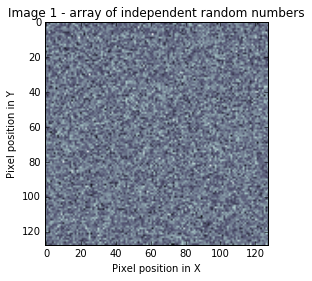

In [4]:
# Constants for image simulations etc
shape = [128, 128] # No of pixels in X, Y
n_voxels = np.prod(shape) # Total pixels
s_fwhm = 8 # Smoothing in number of pixels in x, y
seed = 1939 # Seed for random no generator
alpha = 0.05 # Default alpha level

# Image of independent random nos
np.random.seed(seed) # Seed the generator to get same numbers each time
test_img = np.random.standard_normal(shape)
plt.imshow(test_img)
plt.set_cmap('bone')
plt.xlabel('Pixel position in X')
plt.ylabel('Pixel position in Y')
plt.title('Image 1 - array of independent random numbers')

In this picture, whiter pixels are more positive, darker pixels more
negative.

The Bonferroni correction is the right one for this image, because the
image is made up of 128\*128 = 16384 random numbers from a normal
distribution. Therefore, from the Bonferroni correction
($\alpha / N = 0.05 / 16384$ = [Z equivalent] 4.52), we would
expect only 5 out of 100 such images to have one or more random numbers
in the whole image larger than 4.52.

In [5]:
# Bonferroni threshold for this image
bonf_thresh = inv_n_cdf(1 - (alpha / n_voxels))
print(bonf_thresh)

4.52277137559


The situation changes if we add some spatial correlation to this image.
We can take our image above, and perform the following procedure:

* Break up the image into 8 by 8 squares;

* For each square, calculate the mean of all 64 random numbers in the
  square;

* Replace the 64 random numbers in the square by the mean value.

(In fact, we have one more thing to do to our new image values. When we
take the mean of 64 random numbers, the mean and variance will tend to
zero. We have therefore to multiply our mean numbers by 8 to restore a
variance of 1. This will make the numbers correspond to the normal
distribution again. Why 8? Because the variance of the mean of 64
numbers with variance 1 is 1/64, and so we need to multiply the numbers
by $\sqrt{64}$ to restore a variance of 1. See: [Sum of
uncorrelated
variables](http://en.wikipedia.org/wiki/Variance#Sum_of_uncorrelated_variables_.28Bienaym.C3.A9_formula.29)).

The following is the image that results from the procedure above applied
to our first set of random numbers:

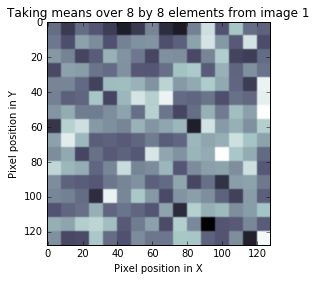

In [6]:
# Divide into FWHM chunks and fill square from mean value
sqmean_img = test_img.copy()
for i in range(0, shape[0], s_fwhm):
    i_slice = slice(i, i+s_fwhm)
    for j in range(0, shape[1], s_fwhm):
        j_slice = slice(j, j+s_fwhm)
        vals = sqmean_img[i_slice, j_slice]
        sqmean_img[i_slice, j_slice] = vals.mean()
# Multiply up to unit variance again
sqmean_img *= s_fwhm
# Show as image
plt.imshow(sqmean_img)
plt.set_cmap('bone')
plt.xlabel('Pixel position in X')
plt.ylabel('Pixel position in Y')
plt.title('Taking means over %s by %s elements from image 1' % (s_fwhm, s_fwhm))

We still have 16384 numbers in our image. However, it is clear that we
now have only (128 / 8) \* (128 / 8) = 256 independent numbers. The
appropriate Bonferroni correction would then be ($\alpha / N$ =
0.05 / 256 = [$Z$ equivalent] 3.55). We would expect that if we
took 100 such mean-by-square-processed random number images, then only 5
of the 100 would have a square of values greater than 3.55 by chance.
However, if we took the original Bonferroni correction for the number of
pixels rather than the number of independent pixels, then our $Z$
threshold would be far too conservative.

# Smoothed images and independent observations

The mean-by-square process we have used above is a form of smoothing. In
the mean-by-square case, the averaging takes place only within the
squares, but in the case of smoothing with a smoothing kernel, the
averaging takes place in a continuous way across the image. We can
smooth our first random number image with a Gaussian kernel of FWHM 8 by
8 pixels. (As for the mean-by-square example, the smoothing reduces the
variance of the numbers in the image, because an average of random
numbers tends to zero. In order to return the variance of the numbers in
the image to one, to match the normal distribution, the image must be
multiplied by a scale factor. The derivation of this scaling factor is
rather technical, and not relevant to the discussion here).

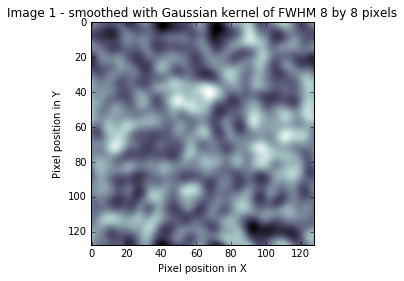

In [7]:
# smooth random number image
import scipy.ndimage as spn
sd = s_fwhm / np.sqrt(8.*np.log(2)) # sigma for this FWHM
stest_img = spn.filters.gaussian_filter(test_img, sd, mode='wrap')

def gauss_2d_varscale(sigma):
    """ Variance scaling for smoothing with 2D Gaussian of sigma `sigma`

    The code in this function isn't important for understanding
    the rest of the tutorial.
    """
    # Make a single 2D Gaussian using given sigma
    limit = sigma * 5 # go to limits where Gaussian will be at or near 0
    x_inds = np.arange(-limit, limit+1)
    y_inds = x_inds # Symmetrical Gaussian (sd same in X and Y)
    [x,y] = np.meshgrid(y_inds, x_inds)
    # http://en.wikipedia.org/wiki/Gaussian_function#Two-dimensional_Gaussian_function
    gf    = np.exp(-(x*x + y*y) / (2 * sigma ** 2))
    gf    = gf/np.sum(gf)
    # Expectation of variance for this kernel
    AG    = np.fft.fft2(gf)
    Pag   = AG * np.conj(AG) # Power of the noise
    COV   = np.real(np.fft.ifft2(Pag))
    return COV[0, 0]

# Restore smoothed image to unit variance
svar = gauss_2d_varscale(sd)
scf = np.sqrt(1 / svar)
stest_img = stest_img * scf

# display smoothed image
plt.imshow(stest_img)
plt.set_cmap('bone')
plt.xlabel('Pixel position in X')
plt.ylabel('Pixel position in Y')
plt.title('Image 1 - smoothed with Gaussian kernel of FWHM %s by %s pixels' %
          (s_fwhm, s_fwhm))

In our smoothed image, as for the mean-by-square image, we no longer
have 16384 independent observations, but some smaller number, because of
the averaging across pixels. If we knew how many independent
observations there were, we could use a Bonferroni correction as we did
for the mean-by-square example. Unfortunately it is not easy to work out
how many independent observations there are in a smoothed image. So, we
must take a different approach to determine our $Z$ score
threshold. One approach used by `SPM` and other packages is to use
Random Field Theory (RFT).

# Using random field theory

You can think of the application of RFT as proceeding in three steps.
First, you determine how many resels there are in your image. Then you
use the resel count and some sophisticated maths to work out the
expected *Euler characteristic* (EC) of your image, when it is
thresholded at various levels. These expected ECs can be used to give
the correct threshold for the required control of false positives
($\alpha$).

# What is a resel?

A resel is a "resolution element". The number of resels in an image is
similar to the number of independent observations in the image. However,
they are not the same, as we will see below. A resel is defined as a
block of pixels of the same size as the FWHM of the smoothness of the
image. In our smoothed image above, the smoothness of the image is 8
pixels by 8 pixels (the smoothing that we applied). A resel is therefore
a 8 by 8 pixel block, and the number of resels in our image is (128 / 8)
\* (128 / 8) = 256. Note that the number of resels depends only on the
number of pixels, and the FWHM.

In [8]:
# No of resels
resels = np.prod(np.array(shape) / float(s_fwhm))
resels

256.0

# What is the Euler characteristic?

The Euler characteristic of an image is a property of the image after it
has been thresholded. For our purposes, the EC can be thought of as the
number of blobs in an image after it has been thresholded. This is best
explained by example. Let us take our smoothed image, and threshold it
at $Z > 2.75$. This means we set to zero all the pixels with
$Z$ scores less than or equal to 2.75, and set to one all the
pixels with $Z$ scores greater than 2.75.

We make a function to show the thresholded image:

In [9]:
def show_threshed(img, th):
    thimg = (img > th)
    plt.figure()
    plt.imshow(thimg)
    plt.set_cmap('bone')
    plt.xlabel('Pixel position in X')
    plt.ylabel('Pixel position in Y')
    plt.title('Smoothed image thresholded at Z > %s' % th)

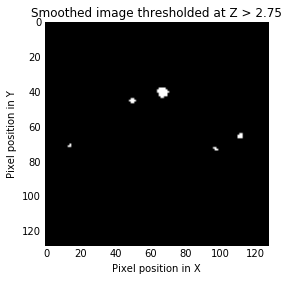

In [10]:
# threshold at 2.75 and display
show_threshed(stest_img, 2.75)

Zero in the image displays as black and one as white. In this picture,
there are some blobs, corresponding to areas with $Z$ scores
higher than 2.75. The EC of this image is just the number of blobs. If
we increase the threshold to $3.25$, we find that some of the
blobs disappear (the highest $Z$ values at the blob peaks were
less than 3.25).

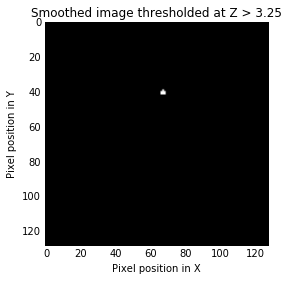

In [11]:
# threshold at 3.25 and display
show_threshed(stest_img, 3.25)

One blob remains; the EC of the image above is therefore 1. It turns out
that if we know the number of resels in our image, it is possible to
estimate the most likely value of the EC at any given threshold. The
formula for this estimate, for two dimensions, is on page 906 of Worsley
1992, implemented below. The graph shows the expected EC of our smoothed
image, of 256 resels, when thresholded at different $Z$ values.

In [12]:
# expected EC at various Z thresholds, for two dimensions
Z = np.linspace(0, 5, 1000)

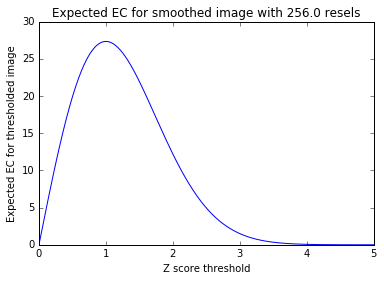

In [13]:
def expected_ec_2d(z, resel_count):
    # From Worsley 1992
    z = np.asarray(z)
    return (resel_count * (4 * np.log(2)) * ((2*np.pi)**(-3./2)) * z) * np.exp((z ** 2)*(-0.5))

expEC = expected_ec_2d(Z, resels)
plt.plot(Z, expEC)
plt.xlabel('Z score threshold')
plt.ylabel('Expected EC for thresholded image')
plt.title('Expected EC for smoothed image with %s resels' % resels)

Note that the graph does a reasonable job of predicting the EC in our
image; at $Z = 2.75$ threshold it predicted an EC of 2.8, and at a
$Z = 3.25 $ it predicted an EC of 0.74

In [14]:
expected_ec_2d([2.75, 3.25], resels)

array([ 2.825 ,  0.7449])

# How does the Euler characteristic give a Z threshold?

The useful feature of the expected EC is this: when the $Z$
thresholds become high and the predicted EC drops towards zero, the
expected EC is a good approximation of the probability of observing one
or more blobs at that threshold. So, in the graph above, when the
$Z$ threshold is set to 4, the expected EC is 0.06. This can be
rephrased thus: the probability of getting one or more regions where
$Z$ is greater than 4, in a 2D image with 256 resels, is 0.06. So,
we can use this for thresholding. If $x$ is the $Z$ score
threshold that gives an expected EC of 0.05, then, if we threshold our
image at $x$, we can expect that any blobs that remain have a
probability of less than or equal to 0.05 that they have occurred by
chance. The threshold $x$ depends only on the number of resels in
our image.

# Is the threshold accurate? Show me!

We can test the treshold with a simulation:

In [15]:
# Simulation to test the RFT threshold.
# Find approx threshold from the vector above.
# We're trying to find the Z value for which the expected EC is 0.05
tmp = (Z > 3) & (expEC<=alpha)
alphaTH = Z[tmp][0]
print('Using Z threshold of %f' % alphaTH)
# Make lots of smoothed images and find how many have one or more
# blobs above threshold
repeats = 1000
falsepos = np.zeros((repeats,))
maxes = np.zeros((repeats,))
edgepix = s_fwhm  # to add edges to image - see below
big_size = [s + edgepix * 2 for s in shape]
i_slice = slice(edgepix + 1, shape[0] + edgepix + 1)
j_slice = slice(edgepix + 1, shape[1] + edgepix + 1)
for i in range(repeats):
    # Make random square with extra edges to throw away
    timg = np.random.standard_normal(size=big_size)
    stimg = spn.filters.gaussian_filter(timg, sd, mode='wrap')
    # throw away edges to avoid artefactually high values
    # at image edges generated by the smoothing
    stimg = stimg[i_slice, j_slice]
    # Reset variance using scale factor from calculation above
    stimg *= scf
    falsepos[i] = np.any(stimg >= alphaTH)
    maxes[i] = stimg.max()
print('False positive rate in simulation was %s (%s expected)' %
      (sum(falsepos) / float(repeats), alpha))

Using Z threshold of 4.054054


False positive rate in simulation was 0.049 (0.05 expected)


# How does the random field correction compare to the Bonferroni correction?

I stated above that the resel count in an image is not exactly the same
as the number of independent observations. If it was the same, then
instead of using RFT for the expected EC, we could use a Bonferroni
correction for the number of resels. However, these two corrections give
different answers. Thus, for an alpha of 0.05, the $Z$ threshold
according to RFT, for our 256 resel image, is $Z=4.05$. However,
the Bonferroni threshold, for 256 independent tests, is 0.05/256 =
[$Z$ equivalent] 3.55. So, although the RFT maths gives us a
Bonferroni-like correction, it is not the same as a Bonferroni
correction. As you can see from the simulation above, the random field
correction gives a threshold very close the the observed value for a
sequence of smoothed images. A Bonferroni correction with the resel
count gives a much lower threshold and would therefore be way off the
correct threshold for 0.05 false positive rate.

# To three dimensions

Exactly the same principles apply to a smoothed random number image in
three dimensions. In this case, the EC is the number of 3D blobs -
perhaps "globules" - of $Z$ scores above a certain threshold.
Pixels might better be described as voxels (pixels with volume). The
resels are now in 3D, and one resel is a cube of voxels that is of size
(FWHM in x) by (FWHM in y) by (FWHM in z). The formula for the expected
EC is different in the 3D case, but still depends only on the resels in
the image. If we find the threshold giving an expected EC of 0.05, in
3D, we have a threshold above which we can expect that any remaining
$Z$ scores are unlikely to have occurred by chance, with a
$p<0.05$.

# More sophisticated random fielding

## Random fields and search volumes

I oversimplified when I said above that the expected EC depends only on
the number of resels in the image. In fact, this is an approximation,
which works well when the volume that we are looking at has a reasonable
number of resels. This is true for our two dimensional example, where
the FWHM was 8 and our image was 128 by 128. However, the precise EC
depends not only on the number of resels, but the shape of the volume in
which the resels are contained. It is possible to derive a formula for
the expected EC, based on the number of resels in the area we are
thresholding, and the shape of the area (see Worsley 1996). This formula
is more precise than the formula taking account of the number of resels
alone. When the area to be thresholded is large, compared to the FWHM,
as is the case when we are thresholding the whole brain, the two
formulae give very similar results. However, when the volume for
thresholding is small, the formulae give different results, and the
shape of the area must be taken into account. This is the case when you
require a threshold for a small volume, such as a region of interest.

## t and F statistic volumes

Keith Worsley's 1996 paper gives the random field formulae for $t$
and $F$ statistics. `SPM` and other imaging packages generate
$t$ and $F$ statistics maps. They use the random fields
formulae for $t$, $F$ to work out the corrected
(family-wise) error rate at each $t$, $F$ value.

## Estimated instead of assumed smoothness

`SPM` and other packages also *estimate* how smooth the images are,
rather than assuming the smoothness as we have done here. `SPM` in
particular looks at the the residuals from the statistical analysis to
calculate the smoothness of the image, in terms of FWHM. From these
calculations it derives estimates for the FWHM in x, y and z. Other than
this, the corrected statistics are calculated just as described above.

# A brain activation example in SPM

Here is an `SPM8` results printout for a first level FMRI analysis.

You will see the FWHM values at the bottom of the page - here they are
4.1 voxels in x, 4.0 voxels in y, and 4.1 voxels in z. These values are
rounded; I can get the exact values from MATLAB by looking at
`xSPM.FWHM`. These are:

In [16]:
FWHM = [4.0528, 4.0172, 4.1192]

A resel is therefore a block of volume approx:

In [17]:
resel_volume = np.prod(FWHM)
print(resel_volume)

67.0643168927


That's the value you see at the bottom the SPM printout after
`resel =`. The resel count of 592.9 in the printout comes from a
calculation based on this estimated FWHM smoothness and the shape of the
brain. In other words it applies the search volume correction I
mentioned above. If it did not apply this correction then the resel
count would simply be the number of voxels divided by the resel volume:

In [18]:
print(44532 / resel_volume)

664.019288697


The table gives statistics for each detected cluster in the analysis,
ordered by significance level. Each line in bold in the table is the
peak voxel for a particular cluster. Lines in standard type are
sub-clusters within the same cluster.

Look at the peak voxel for the third-most significant cluster. This is
the third bold line in the table, and the seventh line overall. On the
left-hand side of the table, you see the values for the "peak-level"
statistics. The extreme left gives the voxel location in millimeters.
Our voxel of interest is at location x=-42, y=18, z=3.

The value in the "T" column for this voxel is 4.89. This is the raw
$t$ statistic. The column $P_{FWE-corr}$ gives the random
field corrected $p$ value. In this case the value is 0.037. 0.037
is the expected EC, in a 3D image of 592.9 resels when thresholded at
$t = 4.89$. This is equivalent to saying that the probability of
getting one or more blobs of $t$ value 4.89 or greater, is 0.037.

There are other corrected $p$ values here, based on cluster size,
and based on the false discovery rate, but I didn't cover those
corrections here.

# References

Worsley, K.J., Marrett, S., Neelin, P., and Evans, A.C. (1992). [A
three-dimensional statistical analysis for CBF activation studies in
human
brain](http://www.math.mcgill.ca/~keith/jcbf/jcbf.abstract.html)
Journal of Cerebral Blood Flow and Metabolism, 12:900-918.

Worsley, K.J., Marrett, S., Neelin, P., Vandal, A.C., Friston, K.J., and
Evans, A.C. (1996). [A unified statistical approach for determining
significant signals in images of cerebral
activation](http://www.math.mcgill.ca/~keith/unified/unified.abstract.html)
Human Brain Mapping, 4:58-73.